In [1]:
import os
from google.colab import drive
drive.mount('/content/drive') # Uncomment when running the notebook for first time
os.chdir("/content/drive/MyDrive/SurgTools")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/SurgTools'

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from torchvision import transforms as T
from torchvision import utils
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm
import numpy as np

In [3]:
# Parse XML files
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.iter('object'):
        obj_dict = {
            'name': obj.find('name').text,
            'bbox': [
                int(obj.find('bndbox/xmin').text),
                int(obj.find('bndbox/ymin').text),
                int(obj.find('bndbox/xmax').text),
                int(obj.find('bndbox/ymax').text)
            ]
        }
        objects.append(obj_dict)
    return objects

In [4]:
def convert_to_coco_targets(labels):
  tools = []
  bboxes = []

  for label in labels:
    tools.append(label['labels'])
    bboxes.append(label['boxes'])

  targets = (tuple(tools), tuple(bboxes))
  return targets

In [5]:
# Visual bounding boxes
def visualize_image(image_path, objects):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR by default
    for obj in objects:
        bbox = obj['bbox']
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(image, obj['name'], (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()


def visualize_image_2(image, objects):
  for obj in objects:
        obj['boxes'] = [int(i) for i in obj['boxes']]
        bbox = obj['boxes']
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(image, obj['labels'], (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
  plt.imshow(image)
  plt.show()

In [6]:
your_label_map = {
    "Grasper": 1,
    "Bipolar": 2,
    "Hook": 3,
    "Scissors": 4,
    "Clipper": 5,
    "Irrigator": 6,
    "SpecimenBag": 7
}


def resize_bbox(bbox, in_size, out_size):
    """
    Adjust bounding box size.
    :param bbox: Original bounding box coordinates in the format [xmin, ymin, xmax, ymax]
    :param in_size: original image size (width, height)
    :param out_size: new image size (width, height)
    :return: adjusted bounding box coordinates
    """
    xmin, ymin, xmax, ymax = bbox
    scale_x = out_size[0] / in_size[0]
    scale_y = out_size[1] / in_size[1]
    xmin = int(xmin * scale_x)
    ymin = int(ymin * scale_y)
    xmax = int(xmax * scale_x)
    ymax = int(ymax * scale_y)
    return [xmin, ymin, xmax, ymax]


class CustomDataset(Dataset):
    def __init__(self, imgs_dir, anns_dir, transforms=None):
        self.imgs_dir = imgs_dir
        self.anns_dir = anns_dir
        self.transforms = transforms

        # Get the names of all image and annotation files, with extensions removed
        anns = set(os.path.splitext(file)[0] for file in os.listdir(anns_dir))
        imgs = anns

        # Keep image file names with matching annotations
        self.imgs = [file + '.jpg' for file in imgs]  # Assuming the image file is in .jpg format
        self.annotations = [file + '.xml' for file in anns]  # Assume that the annotation file is in .xml format

        # Make sure the image and annotation file lists are of equal length
        assert len(self.imgs) == len(self.annotations), "Images and annotations lists are not the same length"

    def __getitem__(self, idx):
        # print("getting")
        img_path = os.path.join(self.imgs_dir, self.imgs[idx])
        ann_path = os.path.join(self.anns_dir, self.annotations[idx])

        # read images
        image = Image.open(img_path).convert("RGB")
        original_size = image.size
        new_size = (480, 480)

        # Parse XML files using parse_xml function
        objects = parse_xml(ann_path)


        boxes = []
        labels = []
        num_objs = len(objects)
        for obj in objects:
            label_name = obj['name']
            label = your_label_map[label_name]  # Convert category name to integer
            labels.append(label)

            # Add bounding box coordinates
            bbox = obj['bbox']
            resized_bbox = resize_bbox(bbox, original_size, new_size)
            boxes.append(resized_bbox)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["image_id"] = idx
        # target["area"] = area
        # target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)  # Apply conversion to image
            # If necessary, you can also convert the target accordingly
            # For example, if random flipping is used, the bounding box of the target needs to be adjusted accordingly

        return image, target

    def __len__(self):
        return len(self.imgs)


In [7]:
from torchvision.transforms import functional as F


# imgs_dir = "/content/m2cai16-tool-locations/JPEGImages"
# anns_dir = "/content/m2cai16-tool-locations/Annotations"

imgs_dir = "./m2cai16-tool-locations/JPEGImages/"
anns_dir = "./m2cai16-tool-locations/Annotations/"

def get_transform(train):
    transforms = []
    # Convert PIL image to PyTorch Tensor
    transforms.append(T.ToTensor())
    # if train:
    #     # Data augmentation during training phase, such as random horizontal flipping
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    #     # More data enhancement operations can be added, such as:
    #     # transforms.append(T.RandomVerticalFlip(0.5))
    #     # transforms.append(T.ColorJitter(...))
    transforms.append(T.Resize((480, 480), antialias=None))  # 以 600x600 为例
    return T.Compose(transforms)


def collate_fn(batch):
    # Stack or pack images and targets separately, because images have different numbers of boxes
    images = [item[0] for item in batch]
    targets = [(item[1]) for item in batch]

    images = default_collate(images)  # Use default stacking method for images
    # Targets do not need to be stacked as they may be of different lengths
    targets = convert_to_coco_targets(targets)
    return images, targets


# Create a dataset instance
dataset = CustomDataset(imgs_dir, anns_dir, transforms=get_transform(True))
# data_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4, collate_fn=collate_fn)

generator2 = torch.Generator()#.manual_seed(42)
split_data = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1], generator=generator2)
train_dataset = split_data[0]
val_dataset = split_data[1]
test_dataset = split_data[2]

# len(train_dataset), len(val_dataset), len(test_dataset)

batchsize = 16
learnrate = 0.002

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_datalaoder = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)


In [8]:
train_dataloader2 = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [8]:
input_, target = next(iter(train_dataloader))

In [9]:
input_.shape

torch.Size([32, 3, 480, 480])

In [8]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler
import torchvision.transforms as T
from torchvision import datasets, ops
from torchvision.models.feature_extraction import create_feature_extractor
from einops import rearrange

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

In [9]:
# CLASSES = [
#     'Grasper', 'Bipolar', 'Hook', 'Scissors', 'Clipper', 'Irrigator',
#     'SpecimenBag', 'empty'
# ]
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush', 'empty'
]


# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098],
          [0.929, 0.694, 0.125], [0.494, 0.184, 0.556],
          [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS *= 100

revert_normalization = T.Normalize(
    mean=[-.485/.229, -.456/.224, -.406/.225],
    std=[1/.229, 1/.224, 1/.225]
)

def plot_im_with_boxes(im, boxes, probs=None, ax=None):

    if ax is None:
        plt.imshow(im)
        ax = plt.gca()

    for i, b in enumerate(boxes.tolist()):
        xmin, ymin, xmax, ymax = b

        patch = plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=COLORS[i], linewidth=2)

        ax.add_patch(patch)
        if probs is not None:
            if probs.ndim == 1:
                cl = probs[i].item()
                text = f'{CLASSES[cl]}'
            else:
                cl = probs[i].argmax().item()
                text = f'{CLASSES[cl]}: {probs[i,cl]:0.2f}'
        else:
            text = ''

        ax.text(xmin, ymin, text, fontsize=7,
                bbox=dict(facecolor='yellow', alpha=0.5))


def preprocess_target(anno, im_w, im_h):

    anno = [obj for obj in anno
            if 'iscrowd' not in obj or obj['iscrowd'] == 0]

    boxes = [obj["bbox"] for obj in anno]
    boxes = torch.as_tensor(
        boxes, dtype=torch.float32).reshape(-1, 4)

    # xywh -> xyxy
    boxes[:, 2:] += boxes[:, :2]
    boxes[:, 0::2].clamp_(min=0, max=im_w)
    boxes[:, 1::2].clamp_(min=0, max=im_h)
    keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
    boxes = boxes[keep]

    classes = [obj["category_id"] for obj in anno]
    classes = torch.tensor(classes, dtype=torch.int64)
    classes = classes[keep]

    # scales boxes to [0,1]
    boxes[:, 0::2] /= im_w
    boxes[:, 1::2] /= im_h
    boxes.clamp_(min=0, max=1)

    boxes = ops.box_convert(boxes, in_fmt='xyxy', out_fmt='cxcywh')
    return classes, boxes

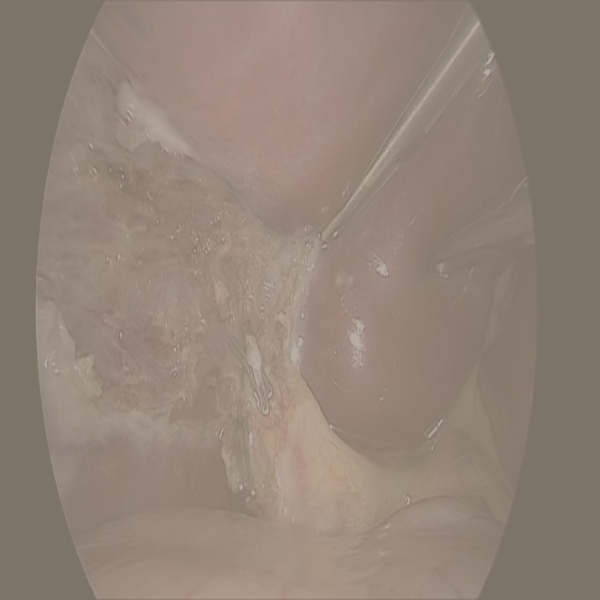

In [ ]:
# # im = input_[0].permute(1, 2, 0)
# im = revert_normalization(input_)[2].clip(0, 1)
# im.shape
# to_image = T.ToPILImage()
# im = to_image(im)
# im

In [ ]:
# t_bbox

tensor([[ 91., -74., 621.,  90.]])

IndexError: tuple index out of range

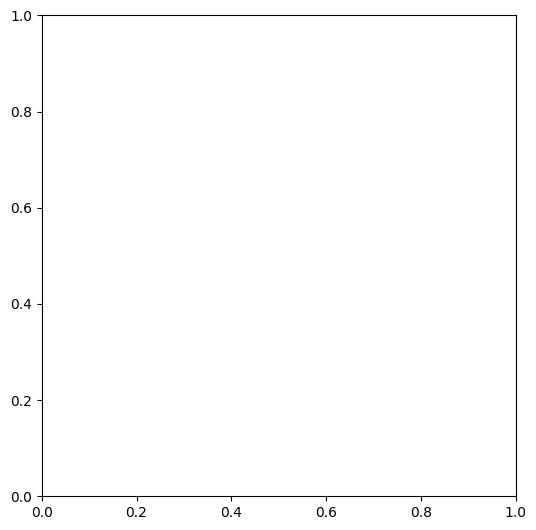

In [ ]:
# ix = 1
# fig = plt.figure(figsize=(10, 10), constrained_layout=True)
# ax = fig.add_subplot(2, 2, 1)
# t_cl = target[0][ix]
# t_bbox = target[1][ix]

# t_bbox = ops.box_convert(
#     t_bbox, in_fmt='cxcywh', out_fmt='xyxy')

# # im = revert_normalization(input_)[ix].\
# #     permute(1,2,0).cpu().clip(0,1)

# im = input_[ix].permute(1, 2, 0)
# print(im.shape)

# ax = fig.add_subplot(2, 2, 1)
# ax.imshow(im)
# # plot_im_with_boxes(im, t_bbox, t_cl, ax=ax)
# # ax.set_axis_off()

In [ ]:
# torch.round(255*(revert_normalization(input_)[ix].\
#         permute(1,2,0).cpu())).type(torch.int64).clip(0,255)

tensor([[[124, 116, 104],
         [124, 116, 104],
         [124, 116, 104],
         ...,
         [124, 116, 104],
         [124, 116, 104],
         [124, 116, 104]],

        [[124, 116, 104],
         [124, 116, 104],
         [124, 116, 104],
         ...,
         [124, 116, 104],
         [124, 116, 104],
         [124, 116, 104]],

        [[124, 116, 104],
         [124, 116, 104],
         [124, 116, 104],
         ...,
         [124, 116, 104],
         [124, 116, 104],
         [124, 116, 104]],

        ...,

        [[124, 116, 104],
         [124, 116, 104],
         [124, 116, 104],
         ...,
         [124, 116, 104],
         [124, 116, 104],
         [124, 116, 104]],

        [[124, 116, 104],
         [124, 116, 104],
         [124, 116, 104],
         ...,
         [124, 116, 104],
         [124, 116, 104],
         [124, 116, 104]],

        [[124, 116, 104],
         [124, 116, 104],
         [124, 116, 104],
         ...,
         [124, 116, 104],
        

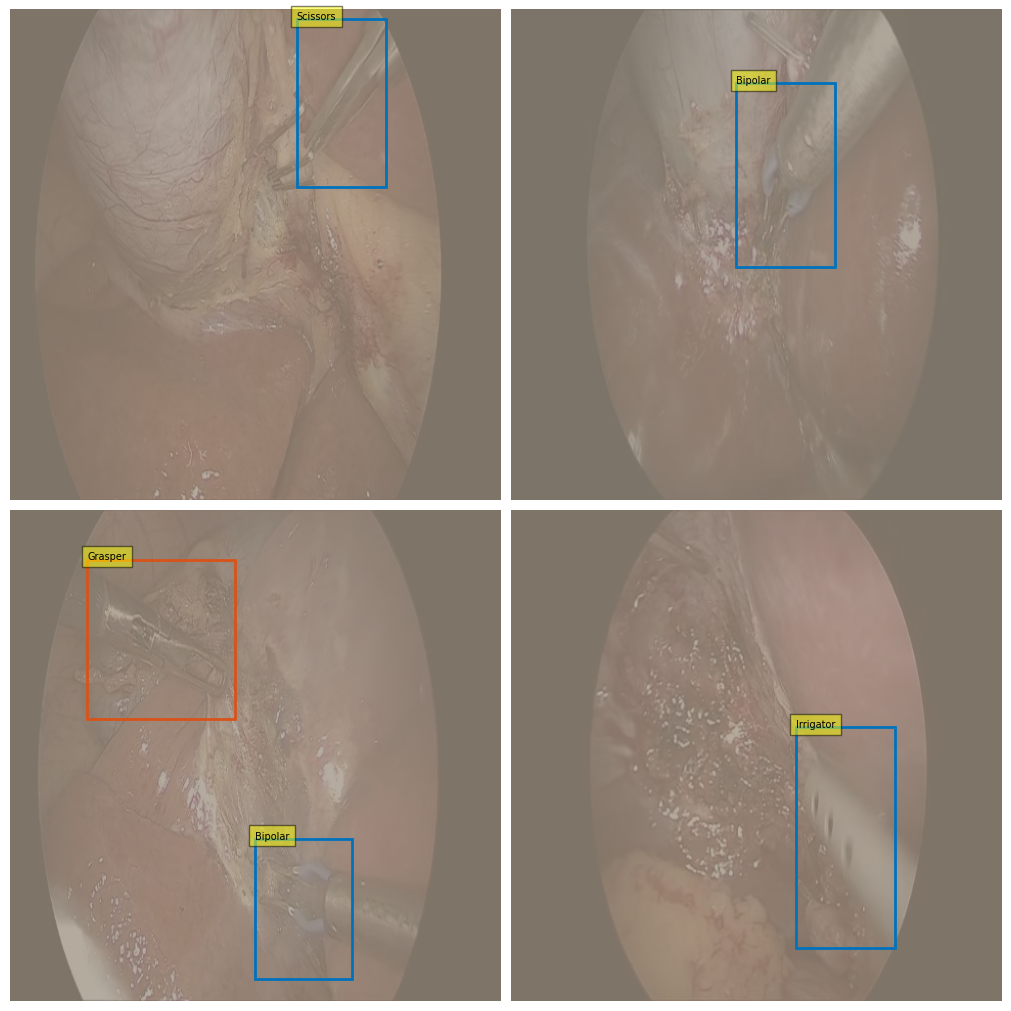

In [13]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)

for ix in range(4):
    t_cl = target[0][ix]
    t_bbox = target[1][ix]

    t_bbox = ops.box_convert(
        t_bbox, in_fmt='xyxy', out_fmt='xyxy')

    im = torch.round(255*(revert_normalization(input_)[ix].\
        permute(1,2,0).cpu())).type(torch.int64).clip(0,255)

    # im = input_[ix].permute(1, 2, 0)
    # print(im.shape)
    # print(t_bbox)

    ax = fig.add_subplot(2, 2, ix+1)
    ax.imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=ax)
    ax.set_axis_off()

In [11]:
# backbone = create_feature_extractor(
#             torch.hub.load('pytorch/vision:v0.10.0',
#                            'resnet50', pretrained=True),
#             return_nodes={'layer4': 'layer4'}
# )

# d_model = 256
# conv1x1 = nn.Conv2d(2048, d_model, kernel_size=10, stride=5)

# x = torch.randn((1, 3, 480, 480))
# embeddings = backbone(x)['layer4']
# embeddings = conv1x1(embeddings)

# print(x.shape, embeddings.shape)
# # torch.Size([1, 3, 480, 480]) torch.Size([1, 256, 15, 15])

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 3, 480, 480]) torch.Size([1, 256, 2, 2])


In [12]:
# embeddings_old = embeddings.clone()
# embeddings = rearrange(embeddings, 'b c h w -> b (h w) c')

# print(embeddings_old.shape, embeddings.shape)
# # torch.Size([1, 256, 15, 15]) torch.Size([1, 225, 256])

torch.Size([1, 256, 2, 2]) torch.Size([1, 4, 256])


In [13]:
# # the original implementation uses sine spatial PE
# n_tokens = 4

# inp_pe = nn.Parameter(
#     torch.rand((1, n_tokens, d_model)),
#     requires_grad=False)

# embeddings += inp_pe

# print(inp_pe.shape, embeddings.shape)
# # torch.Size([1, 225, 256]) torch.Size([1, 225, 256])

torch.Size([1, 4, 256]) torch.Size([1, 4, 256])


In [14]:
# n_heads = 8
# encoder_layer = nn.TransformerEncoderLayer(
#     d_model=d_model, nhead=n_heads, dim_feedforward=4*d_model)

# n_layers = 6
# transformer_encoder = nn.TransformerEncoder(
#     encoder_layer, num_layers=n_layers)

# out_encoder = transformer_encoder(embeddings)

# print(out_encoder.shape)
# # torch.Size([1, 225, 256])

torch.Size([1, 4, 256])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [15]:
# n_queries = 100

# queries = nn.Parameter(
#     torch.rand((1, n_queries, d_model)),
#     requires_grad=False)

# print(queries.shape, embeddings.shape)
# # torch.Size([1, 100, 256]) torch.Size([1, 225, 256])

torch.Size([1, 100, 256]) torch.Size([1, 4, 256])


In [16]:
# decoder_layer = nn.TransformerDecoderLayer(
#     d_model=d_model,
#     nhead=n_heads,
#     dim_feedforward=4*d_model,
#     batch_first=True)

# transformer_decoder = nn.TransformerDecoder(
#     decoder_layer, num_layers=n_layers)

# out_decoder = transformer_decoder(queries, out_encoder)

# print(out_decoder.shape, queries.shape, out_encoder.shape)
# # torch.Size([1, 100, 256]) torch.Size([1, 100, 256]) torch.Size([1, 225, 256])

torch.Size([1, 100, 256]) torch.Size([1, 100, 256]) torch.Size([1, 4, 256])


In [17]:
# n_classes = 8

# linear_class = nn.Linear(d_model, n_classes)
# linear_bbox = nn.Linear(d_model, 4)

# pred_classes = linear_class(out_decoder)
# pred_bboxes = linear_bbox(out_decoder)

# print(pred_classes.shape, pred_bboxes.shape)
# # torch.Size([1, 100, 92]) torch.Size([1, 100, 4])

torch.Size([1, 100, 8]) torch.Size([1, 100, 4])


In [10]:
def get_hook(outs, name):
    def hook(self, input, output):
        outs[name] = output
    return hook


class DETR(nn.Module):

    def __init__(
        self, d_model=256, n_classes=8, n_tokens=225,
        n_layers=6, n_heads=8, n_queries=100
    ):
        super().__init__()

        self.backbone = create_feature_extractor(
            torch.hub.load('pytorch/vision:v0.10.0',
                           'resnet50', pretrained=True),
            return_nodes={'layer4': 'layer4'}
        )

        self.conv1x1 = nn.Conv2d(
            2048, d_model, kernel_size=1, stride=1)

        self.pe_encoder = nn.Parameter(
            torch.rand((1, n_tokens, d_model)),
            requires_grad=True)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model, dropout=0.1)

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=n_layers)

        self.queries = nn.Parameter(
            torch.rand((1, n_queries, d_model)),
            requires_grad=True)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model,
            batch_first=True, dropout=0.1)

        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=n_layers)

        self.linear_class = nn.Linear(d_model, n_classes)
        self.linear_bbox = nn.Linear(d_model, 4)

        # Add hooks to get intermediate outcomes
        self.decoder_outs = {}
        for i, L in enumerate(self.transformer_decoder.layers):
            name = f'layer_{i}'
            L.register_forward_hook(
                get_hook(self.decoder_outs, name))


    def forward(self, x):
        tokens = self.backbone(x)['layer4']
        tokens = self.conv1x1(tokens)
        tokens = rearrange(tokens, 'b c h w -> b (h w) c')

        tokens.shape, self.pe_encoder.shape
        out_encoder = self.transformer_encoder(
            tokens + self.pe_encoder)


        out_decoder = self.transformer_decoder(
            self.queries.repeat(len(out_encoder), 1, 1),
            out_encoder)

        # Compute outcomes for all intermediate
        # decoder's layers
        outs = {}
        for n, o in self.decoder_outs.items():
            outs[n] = {
                'cl': self.linear_class(o),
                'bbox': self.linear_bbox(o)
            }

        return outs

In [11]:
detr = DETR(
    d_model=256, n_classes=92, n_tokens=225,
    n_layers=6, n_heads=8, n_queries=50
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [14]:
x = torch.randn((1, 3, 480, 480))
x = x.to("cuda")
detr = detr.to("cuda")
# outs = detr(x)

In [15]:
detr(x)

{'layer_0': {'cl': tensor([[[ 4.6563e-01, -2.1897e-01,  4.7270e-02, -4.6700e-01,  3.1468e-01,
            -1.5533e-01,  1.1437e-01, -1.6421e-01],
           [ 6.8342e-01,  3.0828e-01,  2.8094e-01, -1.5343e-01,  1.4957e-01,
             6.5772e-01,  4.6495e-01, -1.0473e+00],
           [-6.0934e-01, -1.6042e-01,  6.6280e-01, -9.2478e-01,  1.4624e-01,
            -3.5106e-01, -7.5588e-01, -1.0486e+00],
           [ 7.3150e-01, -5.1154e-01, -4.0321e-01, -1.0254e-01, -7.9128e-01,
            -9.2980e-01,  4.7812e-02, -6.5496e-01],
           [-2.0653e-01,  3.0272e-01,  3.0216e-01, -3.3994e-01, -2.3730e-01,
            -6.3935e-01,  2.2463e-02, -8.1480e-01],
           [ 7.5541e-01, -4.1618e-02,  3.2577e-01,  1.8610e-01,  5.7228e-01,
            -1.9253e-01,  5.6262e-01, -1.1451e+00],
           [ 3.5472e-01,  1.4542e-01,  5.5426e-01, -9.2714e-03,  5.6936e-01,
            -7.1526e-01,  7.1564e-01, -5.2947e-01],
           [ 2.4021e-01,  1.7105e-01,  5.0167e-01, -1.7714e-02,  6.9776e-01,
   

In [13]:
pred_cl, pred_boxes = outs['layer_5'].values()

print(pred_cl.shape, pred_boxes.shape)
# torch.Size([1, 100, 92]) torch.Size([1, 100, 4])

torch.Size([1, 50, 92]) torch.Size([1, 50, 4])


In [16]:
input_.shape

NameError: name 'input_' is not defined

In [ ]:
# train_loader = train_dataloader2

# input_, (tgt_cl, tgt_bbox) = next(iter(train_loader))
# input_ = input_.to("cuda")
# tgt_cl = tgt_cl.to("cuda")
# tgt_bbox = tgt_bbox.to("cuda")
# outs = detr(input_)
# out_cl, out_bbox = outs['layer_5'].values()

# out_bbox = out_bbox.sigmoid()

# o_bbox = out_bbox[0]
# t_bbox = tgt_bbox[0]
# o_cl = out_cl[0]
# t_cl = tgt_cl[0]

# o_probs = o_cl.softmax(dim=-1)

AttributeError: 'tuple' object has no attribute 'to'

In [ ]:
# o_bbox = o_bbox.to("cpu")
# out_cl = out_cl.to("cpu")
# t_bbox = t_bbox.to("cpu")
# tgt_cl = tgt_cl.to("cpu")
# o_probs = o_probs.to("cpu")

In [ ]:
# o_bbox.device

device(type='cpu')

In [ ]:
# # Negative sign here because we want the maximum magnitude
# C_classes = -o_probs[..., t_cl]

# # Positive sign here because we want to shrink the l1-norm
# C_boxes = torch.cdist(o_bbox, t_bbox, p=1)

# # Negative sign here because we want the maximum magnitude
# C_giou = -ops.generalized_box_iou(
#     ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
#     ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
# )

# C_total = 1*C_classes + 5*C_boxes + 2*C_giou

# # Convert the tensor to numpy array
# C_total = C_total.cpu().detach().numpy()

# # Find the optimum pairs that produces the minimum summation.
# # The method returns the pair indices
# o_ixs, t_ixs = linear_sum_assignment(C_total)

# print(t_bbox.shape, o_bbox.shape, C_total.shape)
# out_bbox = out_bbox.sigmoid()

# o_bbox = out_bbox[0]
# t_bbox = tgt_bbox[0]
# o_cl = out_cl[0]
# t_cl = tgt_cl[0]

# o_probs = o_cl.softmax(dim=-1)

# # Negative sign here because we want the maximum magnitude
# C_classes = -o_probs[..., t_cl]
# print(o_bbox.device, t_bbox.device)
# o_bbox = o_bbox.to("cpu")
# # Positive sign here because we want to shrink the l1-norm
# C_boxes = torch.cdist(o_bbox, t_bbox, p=1)

# # Negative sign here because we want the maximum magnitude
# C_giou = -ops.generalized_box_iou(
#     ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
#     ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
# )

# C_total = 1*C_classes + 5*C_boxes + 2*C_giou

# # Convert the tensor to numpy array
# C_total = C_total.cpu().detach().numpy()

# # Find the optimum pairs that produces the minimum summation.
# # The method returns the pair indices
# o_ixs, t_ixs = linear_sum_assignment(C_total)

# print(t_bbox.shape, o_bbox.shape, C_total.shape)
# # torch.Size([26, 4]) torch.Size([100, 4]) (100, 26)

torch.Size([1, 4]) torch.Size([100, 4]) (100, 100)
cuda:0 cpu
torch.Size([1, 4]) torch.Size([100, 4]) (100, 100)


In [ ]:
# # Transform indices to tensors
# o_ixs = torch.IntTensor(o_ixs)
# t_ixs = torch.IntTensor(t_ixs)

# # Reorder o_ixs to naturally align with target_cl length, such
# # the pairs are {(o_ixs[0], t[0]), {o_ixs[1], t[1]}, ...}
# o_ixs = o_ixs[t_ixs.argsort()]

# # Average over the number of boxes, not the number of coordinates
# num_boxes = len(t_bbox)
# loss_bbox = F.l1_loss(
#     o_bbox[o_ixs], t_bbox, reduce='sum') / num_boxes

# # Vectorize the operation
# target_gIoU = ops.generalized_box_iou(
#     ops.box_convert(o_bbox[o_ixs], in_fmt='cxcywh', out_fmt='xyxy'),
#     ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
# )
# # Get only the matrix diagonal that contains the bipartite pairs
# # and transform gIoU into a loss
# loss_giou = 1 - torch.diag(target_gIoU).mean()

# # Assign empty class for the outside predictions
# queries_classes_label = torch.full(o_probs.shape[:1], 91)
# queries_classes_label[o_ixs] = t_cl
# loss_class = F.cross_entropy(o_cl, queries_classes_label)

# loss_total = 1*loss_class + 5*loss_bbox + 2*loss_giou
# print(loss_total)
# # tensor(5.5788, grad_fn=<AddBackward0>)

tensor(1404.3298, grad_fn=<AddBackward0>)


<ipython-input-90-6344d1e3c25e>:11: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([100, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_bbox = F.l1_loss(
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [12]:
def compute_sample_loss(
    o_bbox, t_bbox, o_cl, t_cl, n_queries=10):

    # If  the example has none box, we just feed it with empty classes.
    if len(t_cl) > 0:

        t_bbox = t_bbox.cuda()
        t_cl = t_cl.cuda()

        o_probs = o_cl.softmax(dim=-1)

        # Negative sign here because we want the maximum magnitude
        C_classes = -o_probs[..., t_cl]

        # Positive sign here because we want to shrink the l1-norm
        C_boxes = torch.cdist(o_bbox, t_bbox, p=1)

        # Negative sign here because we want the maximum magnitude
        C_giou = -ops.generalized_box_iou(
            ops.box_convert(o_bbox, in_fmt='xyxy', out_fmt='xyxy'),
            ops.box_convert(t_bbox, in_fmt='xyxy', out_fmt='xyxy')
        )

        C_total = 1*C_classes + 5*C_boxes + 2*C_giou

        # Convert the tensor to numpy array
        C_total = C_total.cpu().detach().numpy()

        # Find the optimum pairs that produces the minimum summation.
        # the method returns the pair indices
        o_ixs, t_ixs = linear_sum_assignment(C_total)

        # Transform indices to tensors
        o_ixs = torch.IntTensor(o_ixs)
        t_ixs = torch.IntTensor(t_ixs)

        # Reorder o_ixs to naturally align with target_cl length, such
        # the pairs are {(o_ixs[0], t[0]), {o_ixs[1], t[1]}, ...}
        o_ixs = o_ixs[t_ixs.argsort()]

        # Average over the number of boxes, not the number of coordinates
        num_boxes = len(t_bbox)
        loss_bbox = F.l1_loss(
            o_bbox[o_ixs], t_bbox, reduce='sum') / num_boxes

        # vectorize the operation
        target_gIoU = ops.generalized_box_iou(
            ops.box_convert(o_bbox[o_ixs], in_fmt='xyxy', out_fmt='xyxy'),
            ops.box_convert(t_bbox, in_fmt='xyxy', out_fmt='xyxy')
        )
        # get only the matrix diagonal that contains the bipartite pairs
        # and transform gIoU into a loss
        loss_giou = 1 - torch.diag(target_gIoU).mean()

        # assign empty class for the outside predictions
        queries_classes_label = torch.full(o_probs.shape[:1], 91).cuda()
        queries_classes_label[o_ixs] = t_cl
        loss_class = F.cross_entropy(o_cl, queries_classes_label)

    else:
        queries_classes_label = torch.full((n_queries,), 91).cuda()
        loss_class = F.cross_entropy(o_cl, queries_classes_label)
        loss_bbox = loss_giou = torch.tensor(0)

    return loss_class, loss_bbox, loss_giou

In [18]:
# Ensure saving directory exists
![ ! -d ckpts-tiny ] && mkdir ckpts-tiny

detr = DETR(d_model=256, n_classes=9, n_tokens=225,
            n_layers=6, n_heads=8, n_queries=50)
detr = detr.to("cuda")

backbone_params = [
    p for n, p in detr.named_parameters() if 'backbone.' in n]

for p in detr.backbone.parameters():
    p.requires_grad = False

transformer_params = [
    p for n, p in detr.named_parameters() if 'backbone.' not in n]

optimizer = AdamW([
    {'params': transformer_params, 'lr': 1e-5},
], weight_decay=1e-4)

nparams = sum([p.nelement() for p in detr.parameters()]) / 1e6
print(f'DETR params: {nparams:.1f}M')
# DETR params: 35.2M

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETR params: 35.2M


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [20]:
# import torch
# import torch.nn as nn
# from torch.optim import AdamW
# from torch.utils.data import DataLoader
# import numpy as np
# import torchvision.ops as ops
# from scipy.optimize import linear_sum_assignment
# import torch.nn.functional as F


# # Ensure saving directory exists
# ! [ ! -d ckpts-tiny ] && mkdir ckpts-tiny

# # ... (rest of your code for detr, backbone_params, etc. remains the same) ...

# torch.set_grad_enabled(True)
# # detr.cuda()  # Comment out to run on CPU for debugging
# detr.train()

# batch_size = 16
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

# # ... (rest of your training loop variables remain the same) ...

# while iters <= niters:

#     for input_, (tgt_cl, tgt_bbox) in train_loader:
#         print(f"Shape of input_ before moving to GPU: {input_.shape}")  # Print the shape
#         # input_ = input_.cuda()  # Comment out to run on CPU for debugging
#         # If you need to use cuda, try this:
#         # input_ = input_.to(device='cuda', non_blocking=True)

#         outs = detr(input_)

#         # ... (rest of your training loop remains the same) ...

NameError: name 'iters' is not defined

In [41]:
torch.set_grad_enabled(True)
detr.cuda()
detr.train()

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

niters = 40000
print_every_n = 1000
save_every_n = 10000
losses = []

hist = []
iters = 1

while iters <= niters:

    for input_, (tgt_cl, tgt_bbox) in train_loader:
        input_ = input_.cuda()

        outs = detr(input_)

        loss = torch.Tensor([0]).cuda()
        for name, out in outs.items():

            out['bbox'] = out['bbox'].sigmoid()

            for o_bbox, t_bbox, o_cl, t_cl in zip(
                out['bbox'], tgt_bbox, out['cl'], tgt_cl):

                loss_class, loss_bbox, loss_giou = compute_sample_loss(
                    o_bbox, t_bbox, o_cl, t_cl)

                sample_loss = 1*loss_class + 5*loss_bbox + 2*loss_giou

                loss += sample_loss / batch_size / len(outs)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()

        # clip gradient norms
        nn.utils.clip_grad_norm_(detr.parameters(), .1)
        optimizer.step()

        losses.append(loss.item())

        if iters % print_every_n == 0:
            loss_avg = np.mean(losses[-10:])
            print_text = f'iters: {iters},\tloss: {loss_avg:.4f}'
            print(print_text)
            print(f'loss_class: {loss_class.item():.4f}\tloss_bbox: {loss_bbox.item():.4f}\tloss_giou: {loss_giou.item():.4f}\t')

            hist.append(loss_avg)
            losses = []

        if iters % save_every_n == 0 and iters > 0:
            str_iters = str(iters)
            str_iters = '0'*(6-len(str_iters)) + str_iters
            torch.save(detr.state_dict(), f'ckpts-tiny/model_it{str_iters}.pt')
            np.save(f'ckpts-tiny/hist_it{str_iters}.npy', hist)

        iters += 1
        if iters > niters:
            break

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


iters: 1000,	loss: 61.3519
loss_class: 0.5321	loss_bbox: 113.6321	loss_giou: 1.1328	
iters: 2000,	loss: 71.6653
loss_class: 0.1886	loss_bbox: 313.5031	loss_giou: 1.2279	
iters: 3000,	loss: 59.4819
loss_class: 0.5905	loss_bbox: 118.5018	loss_giou: 1.1576	
iters: 4000,	loss: 54.7364
loss_class: 0.0615	loss_bbox: 184.7520	loss_giou: 1.1800	
iters: 5000,	loss: 57.4475
loss_class: 0.3235	loss_bbox: 143.6254	loss_giou: 1.2739	
iters: 6000,	loss: 63.7412
loss_class: 0.3407	loss_bbox: 134.3754	loss_giou: 1.2783	


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x783b547e9a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

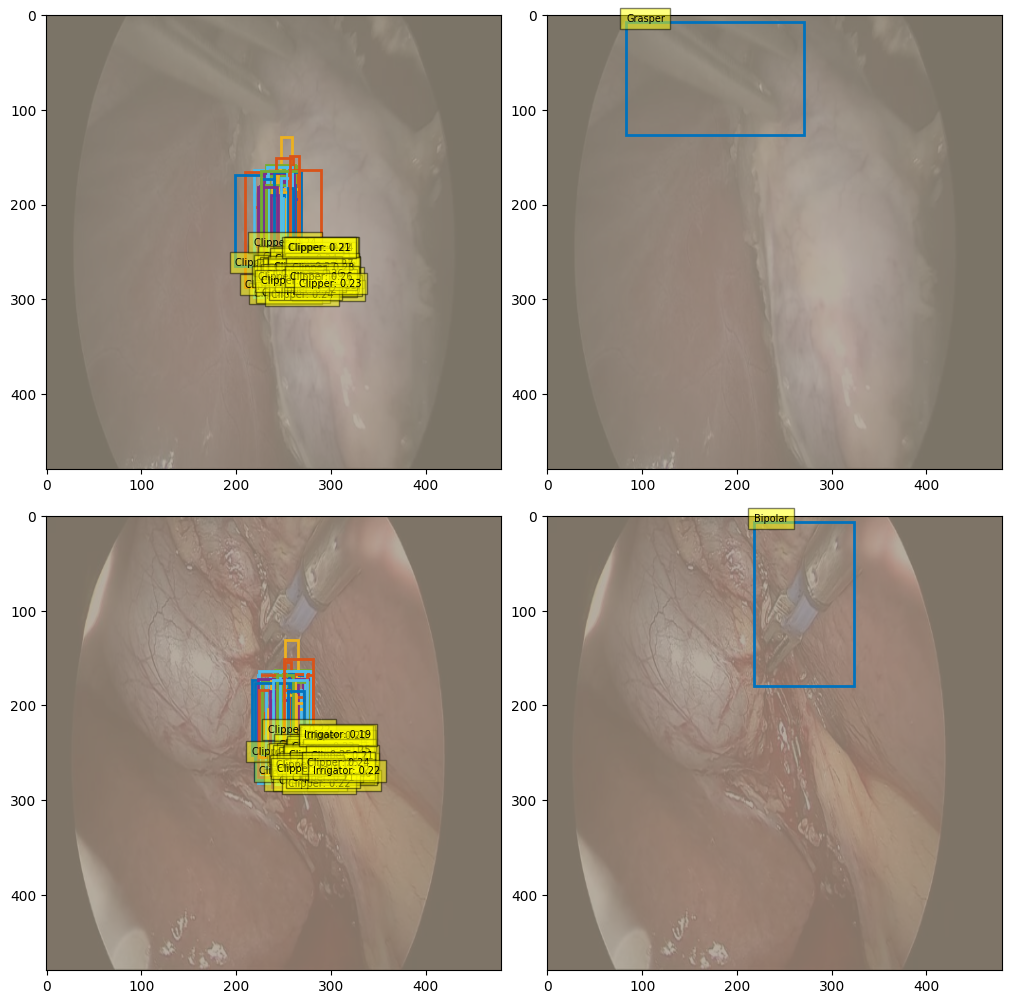

In [19]:
torch.set_grad_enabled(False)
detr.cuda()
detr.eval()

eval_loader = train_dataloader

input_, (tgt_cl, tgt_bbox) = next(iter(eval_loader))[:2]

# out_cl, out_bbox = detr(input_.cuda())
out_cl, out_bbox = detr(input_.cuda())['layer_5'].values()
out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()

fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
# [a.set_axis_off() for a in axs.ravel()]

for ix in range(2):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]

    o_probs = o_cl.softmax(dim=-1)
    o_bbox = ops.box_convert(o_bbox*480, in_fmt='xyxy', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox, in_fmt='xyxy', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) != 91

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])

In [39]:
o_keep

tensor([True, True, True, True, True, True, True, True, True, True])

In [37]:
o_bbox.shape

torch.Size([10, 4])

In [29]:
o_probs[o_keep]

IndexError: index 91 is out of bounds for dimension 0 with size 10

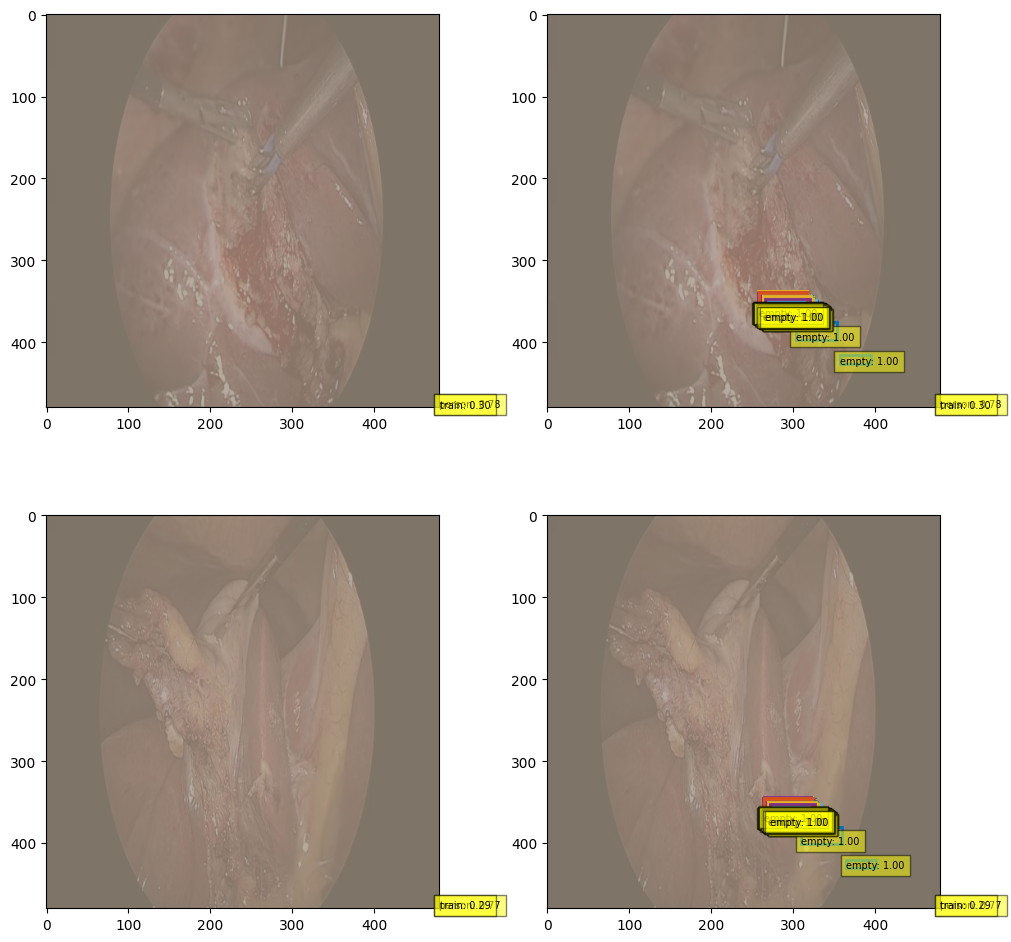

In [23]:
# out_bbox.shape
detr = detr.to("cuda")
torch.set_grad_enabled(False)
detr.eval()

eval_loader = train_dataloader

input_, (tgt_cl, tgt_bbox) = next(iter(eval_loader))[:2]

# out_cl, out_bbox = detr(input_.cuda())
out_cl, out_bbox = detr(input_.cuda())['layer_5'].values()
out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()

fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
# [a.set_axis_off() for a in axs.ravel()]

for ix in range(2):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]

    o_probs = o_cl.softmax(dim=-1)
    o_bbox = ops.box_convert(o_bbox*480, in_fmt='xyxy', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox, in_fmt='xyxy', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) != 91

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    # plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])
    plot_im_with_boxes(im, o_bbox, o_probs, ax=axs[ix, 1])

In [24]:
o_bbox[o_keep]

tensor([[479.5535, 479.5816, 479.5655, 479.6003],
        [479.8130, 479.8042, 479.8308, 479.8159]])

In [43]:
o_bbox[o_keep]

tensor([[479.8057, 479.7320, 479.8542, 479.6299]])

In [28]:
# out_cl, out_bbox = detr(input_.cuda())
out_cl, out_bbox = detr(input_.cuda())['layer_5'].values()
out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()

fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
[a.set_axis_off() for a in axs.ravel()]

for ix in range(1):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]

    o_probs = o_cl.softmax(dim=-1)
    o_bbox = ops.box_convert(o_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) != 91

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


In [14]:
# Ensure saving directory exists
![ ! -d ckpts ] && mkdir ckpts


detr = DETR(
    d_model=256, n_classes=92, n_tokens=225,
    n_layers=6, n_heads=8, n_queries=100
)
detr.cuda()

backbone_params = [
    p for n, p in detr.named_parameters() if 'backbone.' in n]

remaining_params = [
    p for n, p in detr.named_parameters() if 'backbone.' not in n]


optimizer = AdamW([
    {'params': remaining_params, 'lr': 1e-2},
    {'params': backbone_params, 'lr': 1e-2},
], weight_decay=1e-4)


nparams = sum([p.nelement() for p in detr.parameters()]) / 1e6
print(f'DETR params: {nparams:.1f}M')
# DETR params: 35.2M

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETR params: 35.2M


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [20]:
!export CUDA_LAUNCH_BLOCKING=1  # Linux/macOS


In [21]:
!export TORCH_USE_CUDA_DSA=1


In [30]:
detr = detr.to("cpu")
input_ = input_.to("cpu")

In [28]:
input_.cuda()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [15]:
torch.set_grad_enabled(True)
detr.train()

batch_size = 16
train_loader = val_datalaoder


nepochs = 100
losses = []

hist = []


for i_epoch in range(len(hist)+1, nepochs):

    for input_, (tgt_cl, tgt_bbox) in train_loader:
        input_ = input_.cuda()


        outs = detr(input_)

        loss = torch.Tensor([0]).cuda()
        for name, out in outs.items():
            out['bbox'] = out['bbox'].sigmoid()

            for o_bbox, t_bbox, o_cl, t_cl in zip(
                out['bbox'], tgt_bbox, out['cl'], tgt_cl):

                loss_class, loss_bbox, loss_giou = compute_sample_loss(o_bbox, t_bbox, o_cl, t_cl)
                sample_loss = 1*loss_class + 5*loss_bbox + 2*loss_giou
                # sample_loss = loss_bbox
                loss += sample_loss / batch_size #/ len(outs)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()

        # clip gradient norms
        nn.utils.clip_grad_norm_(detr.parameters(), .1)
        optimizer.step()

        losses.append(loss.item())

    if i_epoch % 1 == 0:
        loss_avg = np.mean(losses)
        print_text = f'epoch: {i_epoch},\tloss: {loss_avg:.4f}'
        print(print_text)
        print(f'loss_class: {loss_class.item():.4f}\tloss_bbox: {loss_bbox.item():.4f}\tloss_giou: {loss_giou.item():.4f}\t')

        hist.append(loss_avg)
        losses = []

    if i_epoch % 30 == 0:
        str_epoch = str(i_epoch)
        str_epoch = '0'*(3-len(str_epoch)) + str_epoch

        torch.save(
            {'state':detr.state_dict(),
             'opt': optimizer.state_dict()},
            f'ckpts/model_ep{str_epoch}.pt')

        np.save(f'ckpts/hist-ep{str_epoch}.npy', hist)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


epoch: 1,	loss: 12108.6960
loss_class: 0.1337	loss_bbox: 103.3750	loss_giou: 1.6548	
epoch: 2,	loss: 12103.2696
loss_class: 0.0691	loss_bbox: 186.0000	loss_giou: 1.6310	
epoch: 3,	loss: 12102.9681
loss_class: 0.0587	loss_bbox: 92.2500	loss_giou: 1.7522	
epoch: 4,	loss: 12102.9351
loss_class: 0.0992	loss_bbox: 346.5000	loss_giou: 1.8254	
epoch: 5,	loss: 12102.9097
loss_class: 0.0443	loss_bbox: 128.5000	loss_giou: 1.6660	
epoch: 6,	loss: 12102.9092
loss_class: 0.0596	loss_bbox: 324.5000	loss_giou: 1.9140	
epoch: 7,	loss: 12102.9011
loss_class: 0.0682	loss_bbox: 151.8750	loss_giou: 1.7372	
epoch: 8,	loss: 12102.9006
loss_class: 0.0363	loss_bbox: 268.0000	loss_giou: 1.8706	
epoch: 9,	loss: 12102.8969
loss_class: 0.0703	loss_bbox: 110.1875	loss_giou: 1.7443	
epoch: 10,	loss: 12102.8853
loss_class: 0.0350	loss_bbox: 208.5000	loss_giou: 1.6475	
epoch: 11,	loss: 12102.8843
loss_class: 0.0426	loss_bbox: 282.7500	loss_giou: 1.7016	
epoch: 12,	loss: 12102.8873
loss_class: 0.0424	loss_bbox: 82.694

KeyboardInterrupt: 

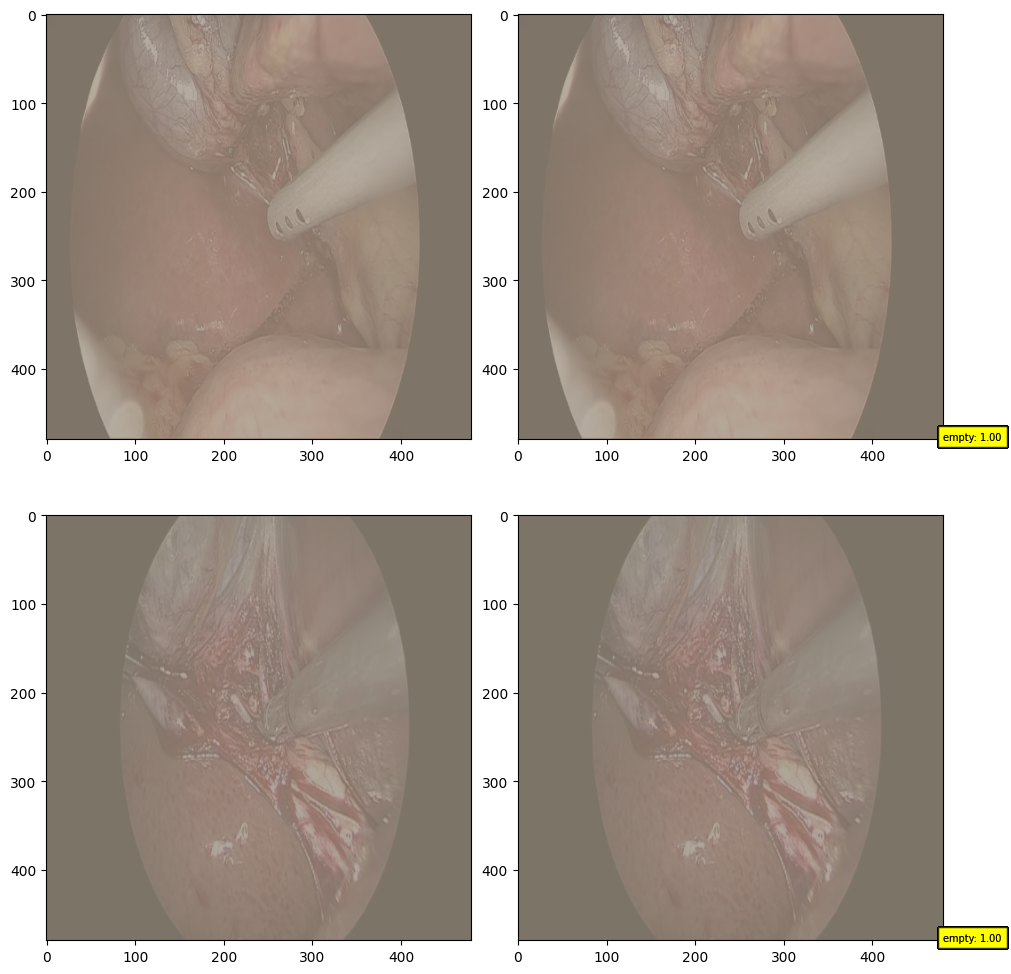

In [17]:
detr = detr.to("cuda")
torch.set_grad_enabled(False)
detr.eval()

eval_loader = val_datalaoder

input_, (tgt_cl, tgt_bbox) = next(iter(eval_loader))[:2]

# out_cl, out_bbox = detr(input_.cuda())
out_cl, out_bbox = detr(input_.cuda())['layer_5'].values()
out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()

fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
# [a.set_axis_off() for a in axs.ravel()]

for ix in range(2):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]

    o_probs = o_cl.softmax(dim=-1)
    o_bbox = ops.box_convert(o_bbox*480, in_fmt='xyxy', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox, in_fmt='xyxy', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) != 91

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    # plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])
    plot_im_with_boxes(im, o_bbox, o_probs, ax=axs[ix, 1])

In [19]:
o_bbox

tensor([[480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480., 480., 480., 480.],
        [480.,